In [132]:
import pandas as pd
import os
import openmatrix as omx
from dbfread import DBF
import math

## Purpose

Write code that will tell you the value of each part of the dCRT equation for any given taz pair

## Background Research

**dCRT Equation (HBW)**

U_dCRT = (asc_dCRT                                                        + 
          asc_CRT                                                         +
          asc_driveacc                                                    +
          asc_transit                                                     +
          asc_motor                                                       +
          utCounty_CRT*ivt_coef_@purp@                                    +
          utCounty*ivt_coef_@purp@                                        +
          daCounty_CRT*ivt_coef_@purp@                                    +
          ivt_coef_@purp@*mw[208][j] - .1*ivt_coef_@purp@*MI.9.T8[j]/100  +
          initwait_coef_@purp@*mw[218][j]                                 +
          walk_coef_1_@purp@*mw[258][j]                                   +
          walk_coef_gt_1_@purp@*mw[288][j]                                +
          drive_coef_@purp@*mw[248][j]                                    +
          xferwait_coef_@purp@*mw[268][j]                                 +
          transfers_coef_drive_@purp@*mw[278][j]                          +
          cost_coef_@purp@*(mw[298][j] + mw[228][j]*@AOC_Auto@)           +
          CBD_dummy_@purp@*zi.1.CBD[j]                                    +
          MIN(0,1+trip_distance_drive_@purp@*(1/(mw[223][j]+.01)))        +
          bus_xfer_@purp@*mw[211][j]                                      +
          zonal_urbanization_@purp@*MIN(200,zi.1.URBANVAL[j])             +
          drive_time_to_ivt_@purp@*(mw[248][j]/mw[208][j])                +
          drive_dist_ratio_@purp@*(mw[228][j]/mw[320][j])                 +
          (-1*EXP(1.11 - .0129*EXP(MIN(10,mw[238][j]))))
         ) / (nest_driveacc*nest_transit*nest_motor)


variable	        mtx file	        matrix (X)	Function
mw[208][j]	        skm_d8_@prd@.mtx	T456789	
MI.9.T8[j]	        skm_d8_@prd@.mtx	T8	
mw[218][j]	        skm_d8_@prd@.mtx	INITWAIT	
mw[258][j]	        skm_d8_@prd@.mtx	WALKTIME	MIN(X, 24)
mw[288][j]	        skm_d8_@prd@.mtx	WALKTIME	MIN(X-24,0)
mw[248][j]	        skm_d8_@prd@.mtx	DRIVETIME	
mw[268][j]	        skm_d8_@prd@.mtx	XFERWAIT	
mw[278][j]	        skm_d8_@prd@.mtx	TRANSFERS	
mw[228][j]	        skm_d8_@prd@.mtx	DRIVEDIST	
zi.1.CBD[j]	        Urbanization.dbf	CBD	
mw[223][j]	        skm_d8_@prd@.mtx	D456789	
mw[211][j]	        skm_d8_@prd@.mtx	1	        if(T4 + T5 + T6 + T9 > 0)
zi.1.URBANVAL[j]	Urbanization.dbf	URBANVAL	
mw[248][j]	        skm_d8_@prd@.mtx	DRIVETIME	
mw[208][j]	        skm_d8_@prd@.mtx	T456789	
mw[228][j]	        skm_d8_@prd@.mtx	DRIVEDIST	
mw[320][j]	        skm_auto_@prd@.mtx	dist_GP	
mw[238][j]	        skm_d8_@prd@.mtx	D8	


## Inputs

In [146]:
purp_C = 'HBW'   # HBW  HBO  NHB  HBC
purp_L = purp_C.lower()

pkok   = 'pk'      # pk  ok (unless HBC, then only pk)
pkok_C = pkok.capitalize()

autoown = "1veh" # 0veh  1veh  2veh  all

income = 'lowinc'   # lowinc  highinc

# from GenParam File
AOC_Auto     = 21.7
utCounty     = 0
utCounty_CRT = 0
daCounty_CRT = 0


In [ ]:
parent_path = r'D:\\GitHub\\WF-TDM-v9x'

#asc_path   = f"_scripts\\_data\\2.10\\{purp_C}_MC_constants_{pkok}_0.txt"       #f"2_ModelScripts\\4_ModeChoice\\coeffs\\{purp_C}_MC_constants_{pkok}_0.txt"
#coeff_path = f"_scripts\\_data\\2.10\\{purp_C}_MC_coefficients.txt"             #f"2_ModelScripts\\4_ModeChoice\\coeffs\\{purp_C}_MC_coefficients.txt"

#skm_d8_path   = f"..\\..\\_large-files\\WF-TDM-v9x-v920-E2\\E2.10\\skm_d8_{pkok_C}.omx"
#skm_auto_path = f"..\\..\\_large-files\\WF-TDM-v9x-v920-E2\\E2.10\\skm_auto_{pkok_C}.omx"

urb_path = parent_path + r"/_scripts/_data/2.10/Urbanization.dbf"

#### Constants

In [170]:
import os
import pandas as pd

# Define purps and peaks
purps = ['HBW', 'HBO', 'NHB', 'HBC']
peaks = ['Pk', 'Ok']

# Initialize an empty list to collect all DataFrames
asc_list = []

# Loop through each combination of purp and pkok
for purp in purps:
    for pkok in peaks:
        # Construct the file path
        asc_path = f"_scripts\\_data\\2.10\\{purp}_MC_constants_{pkok}_0.txt"
        full_path = os.path.join(parent_path, asc_path)

        # Check if the file exists
        if not os.path.exists(full_path):
            print(f"File not found, skipping: {full_path}")
            continue  # Skip to the next iteration

        # Parse the file and extract key-value pairs
        parsed_data = []
        with open(full_path) as file:
            for line in file:
                if "=" in line:
                    key, value = line.split("=")
                    parsed_data.append([key.strip(), float(value.strip())])

        # Convert to a DataFrame
        df_a = pd.DataFrame(parsed_data, columns=["Variable", "Value"])
        
        # For NHB and HBC, set AutoOwn to "all"
        if purp in ['NHB', 'HBC']:
            df_a['AutoOwn'] = 'all'
        else:
            df_a['AutoOwn'] = df_a['Variable'].str.split('_').str[-1]
            df_a['Variable'] = df_a['Variable'].str.rsplit('_', n=1).str[0]

        # Add purp and pkok as new columns
        df_a['Purpose'] = purp
        df_a['PkOk'] = pkok

        # Store in the list
        asc_list.append(df_a)

# Combine all DataFrames into one
df_asc = pd.concat(asc_list, ignore_index=True)

# Display the combined DataFrame
display(df_asc)


File not found, skipping: D:\\GitHub\\WF-TDM-v9x\_scripts\_data\2.10\HBC_MC_constants_Ok_0.txt


,Variable,Value,AutoOwn,Purpose,PkOk
0,asc_motor,0.0000,0veh,HBW,Pk
1,asc_motor,0.0000,1veh,HBW,Pk
2,asc_motor,0.0000,2veh,HBW,Pk
3,asc_motor,0.0000,all,HBW,Pk
4,asc_nonmotor,3.1830,0veh,HBW,Pk
...,...,...,...,...,...
546,asc_dBRT,1.1779,all,HBC,Pk
547,asc_dLRT,0.3957,all,HBC,Pk
548,asc_dCRT,0.8122,all,HBC,Pk
549,asc_walk,0.0000,all,HBC,Pk


In [ ]:
#purps = ['hbw','hbo','nhb','hbc']
#peaks = ['pk','ok']
#
#asc_path   = f"_scripts\\_data\\2.10\\{purp_C}_MC_constants_{pkok}_0.txt"
#
## Read the file and process the contents
#parsed_data = []
#with open(os.path.join(parent_path,asc_path)) as file:
#    for line in file:
#        if "=" in line:
#            key, value = line.split("=")
#            parsed_data.append([key.strip(), float(value.strip())])
#
## Convert to a DataFrame
#df_asc = pd.DataFrame(parsed_data, columns=["Variable", "Value"])
#df_asc['AutoOwn'] = df_asc['Variable'].str.split('_').str[-1]
#df_asc['Variable'] = df_asc['Variable'].str.rsplit('_', n=1).str[0]
#
## Filter to correct auto ownership number
##df_asc = df_asc[df_asc['AutoOwn']==autoown]
#
## Set variables dynamically
#for _, row in df_asc.iterrows():
#    globals()[row['Variable']] = row['Value']
#
## Display the DataFrame
#display(df_asc)


,Variable,Value,AutoOwn
0,asc_motor,0.0000,0veh
1,asc_motor,0.0000,1veh
2,asc_motor,0.0000,2veh
3,asc_motor,0.0000,all
4,asc_nonmotor,3.1830,0veh
...,...,...,...
111,asc_walk,0.0000,all
112,asc_bike,0.0000,0veh
113,asc_bike,0.0000,1veh
114,asc_bike,0.0000,2veh


#### Coefficients

In [175]:
import os
import pandas as pd

# Define purps
purps = ['HBW', 'HBO', 'NHB', 'HBC']

# Initialize an empty list to collect all DataFrames
coef_list = []

# Loop through each purp
for purp in purps:
    # Construct the file path
    coeff_path = f"_scripts\\_data\\2.10\\{purp}_MC_coefficients.txt"
    full_path = os.path.join(parent_path, coeff_path)

    # Check if the file exists
    if not os.path.exists(full_path):
        print(f"File not found, skipping: {full_path}")
        continue  # Skip to the next iteration

    # Read the file, keeping only lines with '='
    with open(full_path) as f:
        lines = [line.strip() for line in f if "=" in line]

    # Ensure correct splitting
    data = []
    for line in lines:
        parts = line.split("=", 1)  # Split only on the first '='
        if len(parts) == 2:
            param, value = parts[0].strip(), parts[1].split(";")[0].strip()  # Remove comments
            data.append((param, value))

    # Convert to DataFrame & split up param and purpose
    df_co = pd.DataFrame(data, columns=["Parameter", "Value"])
    df_co["Value"] = pd.to_numeric(df_co["Value"], errors="ignore")

    df_co['Purpose'] = df_co['Parameter'].str.split('_').str[-1]
    df_co['Purpose'] = df_co['Purpose'].apply(lambda x: x.upper())
    df_co['Parameter'] = df_co['Parameter'].str.rsplit('_', n=1).str[0]

    # Store in the list
    coef_list.append(df_co)

# Combine all DataFrames into one
df_coef = pd.concat(coef_list, ignore_index=True)

# Display the combined DataFrame
display(df_coef)


C:\Users\cday\AppData\Local\Temp\ipykernel_30100\896962971.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_co["Value"] = pd.to_numeric(df_co["Value"], errors="ignore")
C:\Users\cday\AppData\Local\Temp\ipykernel_30100\896962971.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_co["Value"] = pd.to_numeric(df_co["Value"], errors="ignore")
C:\Users\cday\AppData\Local\Temp\ipykernel_30100\896962971.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_co["Value"] = pd.to_numeric(df_co["Value"], errors="ignore")
C:\Users\cday\AppData\Local\Temp\ipykernel_30100\896962971.py:35: FutureWarning: errors='ignore' is deprecated and will r

,Parameter,Value,Purpose
0,ivt_coef,-0.045,HBW
1,initwait_coef,-0.090,HBW
2,xferwait_coef,-0.090,HBW
3,walk_coef_1,-0.090,HBW
4,walk_coef_gt_1,-0.135,HBW
...,...,...,...
75,trip_distance_walk,0.000,HBC
76,trip_distance_drive,-1.000,HBC
77,CBD_dummy,0.000,HBC
78,CBD_dummy_walk,0.000,HBC


In [ ]:
#coeff_path = f"_scripts\\_data\\2.10\\{purp_C}_MC_coefficients.txt"
#
## Read the file, keeping only lines with '='
#with open(os.path.join(parent_path,coeff_path)) as f:
#    lines = [line.strip() for line in f if "=" in line]
#
## Ensure correct splitting
#data = []
#for line in lines:
#    parts = line.split("=", 1)  # Split only on the first '='
#    if len(parts) == 2:
#        param, value = parts[0].strip(), parts[1].split(";")[0].strip()  # Remove comments
#        data.append((param, value))
#
## Convert to DataFrame & split up param and purpose
#df_coef = pd.DataFrame(data, columns=["Parameter", "Value"])
#df_coef["Value"] = pd.to_numeric(df_coef["Value"], errors="ignore")
#df_coef['Purpose'] = df_coef['Parameter'].str.split('_').str[-1]
#df_coef['Parameter'] = df_coef['Parameter'].str.rsplit('_', n=1).str[0]
#
## Set variables dynamically
#for _, row in df_coef.iterrows():
#    globals()[row['Parameter']] = row['Value']
#
## Display result
#display(df_coef)


C:\Users\cday\AppData\Local\Temp\ipykernel_30100\1235846293.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_coef["Value"] = pd.to_numeric(df_coef["Value"], errors="ignore")


,Parameter,Value,Purpose
0,ivt_coef,-0.0450,hbw
1,initwait_coef,-0.0900,hbw
2,xferwait_coef,-0.0900,hbw
3,walk_coef_1,-0.0900,hbw
4,walk_coef_gt_1,-0.1350,hbw
5,drive_coef,-0.0675,hbw
6,bike_coef,-0.0900,hbw
7,cost_lowinc_coef,-0.0050,hbw
8,cost_highinc_coef,-0.0020,hbw
9,parkcost_lowinc_coef,-0.0050,hbw


In [ ]:
## determine based on income
#if (income=='lowinc'):
#    cost_coef = cost_lowinc_coef
#    parkcost_coef = parkcost_lowinc_coef
#else:
#    cost_coef = cost_highinc_coef
#    parkcost_coef = parkcost_highinc_coef

### Skims

In [176]:
import os
import pandas as pd
import openmatrix as omx  # Make sure you have the openmatrix package installed

# Define peaks
peaks = ['Ok', 'Pk']

# List of keys to extract
keys = ['T456789', 'T4', 'T5', 'T6', 'T8', 'T9', 'INITWAIT', 'WALKTIME', 'DRIVETIME', 'XFERWAIT', 'TRANSFERS', 'XFARE', 'DRIVEDIST', 'D456789', 'D8']

# Initialize an empty list to store DataFrames
omx_list = []

# Loop through each pkok value
for pkok in peaks:
    # Construct OMX file path
    skm_d8_path = f"..\\..\\_large-files\\WF-TDM-v9x-v920-E2\\E2.10\\skm_d8_{pkok}.omx"
    skm_auto_path = f"..\\..\\_large-files\\WF-TDM-v9x-v920-E2\\E2.10\\skm_auto_{pkok}.omx"

    # Check if the file exists, and skip if not
    if not os.path.exists(skm_d8_path) or not os.path.exists(skm_auto_path):
        print(f"File not found, skipping: {skm_d8_path} or {skm_auto_path}")
        continue
    
    # Open the OMX file
    skm_d8 = omx.open_file(skm_d8_path)

    # Initialize an empty DataFrame for the current pkok
    df_skm_d8 = pd.DataFrame()

    # Loop through each key and process the DataFrame
    for key in keys:
        df = pd.DataFrame(skm_d8[key])
        df = df.reset_index().melt(id_vars='index', var_name='a_TAZID', value_name=key)
        df.rename(columns={'index': 'p_TAZID'}, inplace=True)
        
        # Merge with the combined DataFrame
        if df_skm_d8.empty:
            df_skm_d8 = df
        else:
            df_skm_d8 = pd.merge(df_skm_d8, df, on=['p_TAZID', 'a_TAZID'], how='outer')

    # Close the OMX file
    skm_d8.close()

    # Open the second OMX file to get the extra field
    skm_auto = omx.open_file(skm_auto_path)
    df_skm_auto = pd.DataFrame(skm_auto['dist_GP'])
    df_skm_auto = df_skm_auto.reset_index().melt(id_vars='index', var_name='a_TAZID', value_name='dist_GP')
    df_skm_auto.rename(columns={'index': 'p_TAZID'}, inplace=True)
    skm_auto.close()

    # Merge the extra field with the combined DataFrame
    df_skms = pd.merge(df_skm_d8, df_skm_auto, on=['p_TAZID', 'a_TAZID'], how='outer')

    # Fix index since Cube starts at 1 and Python starts at 0
    df_skms['p_TAZID'] = df_skms['p_TAZID'].astype(int) + 1
    df_skms['a_TAZID'] = df_skms['a_TAZID'].astype(int) + 1

    # Add the pkok as a new column
    df_skms['PkOk'] = pkok

    # Append to the list
    omx_list.append(df_skms)

# Concatenate all DataFrames into one
df_all_skms = pd.concat(omx_list, ignore_index=True)

# Display the combined DataFrame
display(df_all_skms)

,p_TAZID,a_TAZID,T456789,T4,T5,T6,T8,T9,INITWAIT,WALKTIME,DRIVETIME,XFERWAIT,TRANSFERS,XFARE,DRIVEDIST,D456789,D8,dist_GP,PkOk
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48,Ok
1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,Ok
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.22,Ok
3,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.07,Ok
4,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.05,Ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26339277,3629,3625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.94,Pk
26339278,3629,3626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.48,Pk
26339279,3629,3627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.74,Pk
26339280,3629,3628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.11,Pk


In [ ]:
## Open the OMX file once
#f"..\\..\\_large-files\\WF-TDM-v9x-v920-E2\\E2.10\\skm_d8_{pkok_C}.omx"
#skm_d8 = omx.open_file(skm_d8_path)
#
## List of keys you want to extract
#keys = ['T456789', 'T4', 'T5', 'T6', 'T8', 'T9', 'INITWAIT', 'WALKTIME', 'DRIVETIME', 'XFERWAIT', 'TRANSFERS', 'XFARE', 'DRIVEDIST', 'D456789', 'D8']
#
## Initialize an empty DataFrame
#df_skm_d8 = pd.DataFrame()
#
## Loop through each key and process the DataFrame
#for key in keys:
#    df = pd.DataFrame(skm_d8[key])
#    df = df.reset_index().melt(id_vars='index', var_name='a_TAZID', value_name=key)
#    df.rename(columns={'index': 'p_TAZID'}, inplace=True)
#    
#    # Merge with the combined DataFrame
#    if df_skm_d8.empty:
#        df_skm_d8 = df
#    else:
#        df_skm_d8 = pd.merge(df_skm_d8, df, on=['p_TAZID', 'a_TAZID'], how='outer')
#
## Close the OMX file
#skm_d8.close()
#
## Open the second OMX file to get the extra field
#skm_auto = omx.open_file(skm_auto_path)
#df_skm_auto = pd.DataFrame(skm_auto['dist_GP'])
#df_skm_auto = df_skm_auto.reset_index().melt(id_vars='index', var_name='a_TAZID', value_name='dist_GP')
#df_skm_auto.rename(columns={'index': 'p_TAZID'}, inplace=True)
#skm_auto.close()
#
## Merge the extra field with the combined DataFrame
#df_skms = pd.merge(df_skm_d8, df_skm_auto, on=['p_TAZID', 'a_TAZID'], how='outer')
#
## fix index since cube starts at 1 and pythons tarts at 0
#df_skms['p_TAZID'] = df_skms['p_TAZID'].astype(int) + 1
#df_skms['a_TAZID'] = df_skms['a_TAZID'].astype(int) + 1
#

### Urbanization

In [ ]:
urb_path = parent_path + r"/_scripts/_data/2.10/Urbanization.dbf"
df_urb = pd.DataFrame(iter(DBF(urb_path, load=True)))[['Z','CBD','URBANVAL']]
df_urb

,Z,CBD,URBANVAL
0,1,0,0.13
1,2,0,0.13
2,3,0,0.14
3,4,0,0.14
4,5,0,0.13
...,...,...,...
3541,3542,0,1.22
3542,3543,0,0.07
3543,3544,0,0.04
3544,3545,0,0.02


## Utility Calculations

In [184]:
# selected values
sel_purp          = "HBW"    # HBW     HBO      NHB   HBC
sel_pkok          = 'Pk'     # Pk      Ok       
sel_autoown       = "1veh"   # 0veh    1veh     2veh  all
sel_income        = 'lowinc'  # lowinc  highinc  
sel_p             = 3195
sel_a             = 1027

# from GenParam File
AOC_Auto     = 21.7
utCounty     = 0
utCounty_CRT = 0
daCounty_CRT = 0


In [181]:
# Select ASC --------------------------------------------------------------------------#
#Filter asc file to correct purpose and pkok and autoown
df_asc_selected = df_asc[df_asc['AutoOwn']==sel_autoown]
df_asc_selected = df_asc_selected[df_asc_selected['Purpose']==sel_purp]
df_asc_selected = df_asc_selected[df_asc_selected['PkOk']==sel_pkok]
df_asc_selected

# Set variables dynamically
for _, row in df_asc_selected.iterrows():
    globals()[row['Variable']] = row['Value']

In [182]:
# Select Coef --------------------------------------------------------------------------#
#Filter coef file to correct purpose
df_coef_selected = df_coef[df_coef['Purpose']==sel_purp]

# Set variables dynamically
for _, row in df_coef_selected.iterrows():
    globals()[row['Parameter']] = row['Value']

# determine based on income
if (sel_income=='lowinc'):
    cost_coef = cost_lowinc_coef
    parkcost_coef = parkcost_lowinc_coef
else:
    cost_coef = cost_highinc_coef
    parkcost_coef = parkcost_highinc_coef

In [ ]:
# Select Skims --------------------------------------------------------------------------#
df_all_skms_selected = df_all_skms[df_all_skms['PkOk']==sel_pkok]
df_all_skms_selected

# select given p and a taz for skims
df_skms_selected = df_skms[(df_skms['p_TAZID'] == sel_p) & (df_skms['a_TAZID'] == sel_a)]

# Loop through each column and set the variable name to its value
for column in df_skms_selected.columns:
    if column not in ['p_TAZID', 'a_TAZID']:
        globals()[column] = df_skms_selected.iloc[0][column]

# select given p and a for urbanization
df_urb_selected = df_urb[df_urb['Z']==sel_a]

# Loop through each column and set the variable name to its value
for column in df_urb_selected.columns:
    if column not in ['Z']:
        globals()[column] = df_urb_selected.iloc[0][column]

In [186]:
asc_dCRT
asc_CRT
asc_driveacc
asc_transit
asc_motor

ut_crt_util = utCounty_CRT * ivt_coef
da_crt_util = daCounty_CRT * ivt_coef
ut_util     = utCounty     * ivt_coef

asc_combined = asc_dCRT + asc_CRT + asc_driveacc + asc_transit + asc_motor
co_combined_util = ut_crt_util + da_crt_util + ut_util

In [187]:
ivt_util                = ivt_coef * T456789 - .1 * ivt_coef*T8 / 100
initwait_util           = initwait_coef * INITWAIT
walk_util_1             = walk_coef_1 * min(WALKTIME, 24)
walk_util_gt_1          = walk_coef_gt_1 * max(WALKTIME-24, 0)
drive_util              = drive_coef * DRIVETIME
xferwait_util           = xferwait_coef * XFERWAIT
transfers_drive_util    = transfers_coef_drive * TRANSFERS
cost_util               = cost_coef * (XFARE + DRIVEDIST * AOC_Auto)
CBD_util                = CBD_dummy * CBD
trip_distance_util      = min(0, 1 + trip_distance_drive * (1 / (D456789 + 0.1)))
bus_xfer_util           = bus_xfer * (1 if (T4 + T5 + T6 + T9) > 0 else 0)
zonal_urbanization_util = zonal_urbanization * min(200, URBANVAL)
drive_time_to_ivt_util  = drive_time_to_ivt * (DRIVETIME / T456789)
drive_dist_ratio_util   = drive_dist_ratio * (DRIVEDIST / dist_GP)
short_trips_util        = -1 * math.exp(1.11 - 0.0129 * math.exp(min(10, D8)))

In [188]:
total = (
    asc_combined + 
    co_combined_util + 
    ivt_util +
    initwait_util +
    walk_util_1 +
    walk_util_gt_1 +
    drive_util  +
    xferwait_util +
    transfers_drive_util +
    cost_util +
    CBD_util +
    trip_distance_util +
    bus_xfer_util +
    zonal_urbanization_util +
    drive_time_to_ivt_util +
    drive_dist_ratio_util +
    short_trips_util
)
total

-9.793172758013121

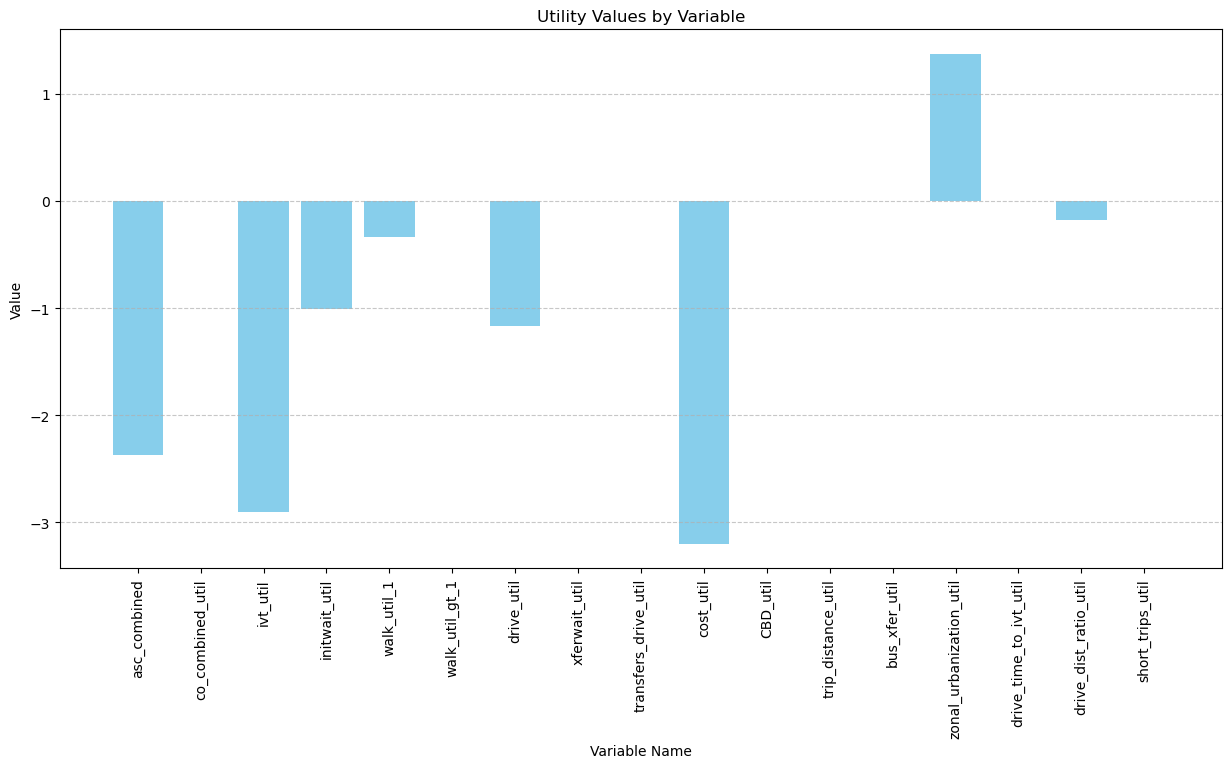

In [189]:
import matplotlib.pyplot as plt

# Create a dictionary of the variables and their values
data = {
    'asc_combined': asc_combined,
    'co_combined_util': co_combined_util,
    'ivt_util': ivt_util,
    'initwait_util': initwait_util,
    'walk_util_1': walk_util_1,
    'walk_util_gt_1': walk_util_gt_1,
    'drive_util': drive_util,
    'xferwait_util': xferwait_util,
    'transfers_drive_util': transfers_drive_util,
    'cost_util': cost_util,
    'CBD_util': CBD_util,
    'trip_distance_util': trip_distance_util,
    'bus_xfer_util': bus_xfer_util,
    'zonal_urbanization_util': zonal_urbanization_util,
    'drive_time_to_ivt_util': drive_time_to_ivt_util,
    'drive_dist_ratio_util': drive_dist_ratio_util,
    'short_trips_util': short_trips_util
}

# Extract names and values
names = list(data.keys())
values = list(data.values())

# Create the bar plot
plt.figure(figsize=(15, 7))
plt.bar(names, values, color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Variable Name')
plt.ylabel('Value')
plt.title('Utility Values by Variable')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
